In [7]:
import sys
sys.path.append('libsigma/')
import os
import read_and_write as rw
import geopandas as gpd
import numpy as np
from osgeo import gdal

In [42]:
def rasterize_emprise(in_vector,out_image,field_name,sptial_resolution):
# define command pattern to fill with paremeters
  cmd_pattern = ("gdal_rasterize -a {field_name} "
                "-tr {sptial_resolution} {sptial_resolution} "
                "-ot Byte -of GTiff "
                "-a_nodata 0 "
                "{in_vector} {out_image}")
  
  # fill the string with the parameter thanks to format function
  cmd = cmd_pattern.format(in_vector=in_vector, out_image=out_image, 
                          field_name=field_name,sptial_resolution=sptial_resolution)
  
  # execute the command in the terminal
  print(cmd)
  os.system(cmd)

In [47]:
emprise = 'data/project/emprise_etude.shp'
field_name = 'minx'
output_emprise = 'data/project/emprise.tif'
sptial_resolution = 10.0
rasterize_emprise(emprise,output_emprise,field_name,sptial_resolution)

gdal_rasterize -a minx -tr 10.0 10.0 -ot Byte -of GTiff -a_nodata 0 data/project/emprise_etude.shp data/project/emprise.tif
0...10...20...30...40...50...60...70...80...90...100 - done.


In [48]:
def get_img_extend(image_filename):
  dataset = rw.open_image(image_filename)
  geotransform = dataset.GetGeoTransform()
  minx = geotransform[0]  # Origine X
  maxy = geotransform[3]  # Origine Y
  maxx = minx + geotransform[1] * dataset.RasterXSize  
  miny = maxy + geotransform[5] * dataset.RasterYSize
  return minx, miny, maxx, maxy  

In [49]:
def code_vege(shapefile_path_vege,shapefile_path_emprise,output_path):
   
    # Charger le fichier shapefile
    gdf_vegetation = gpd.read_file(shapefile_path_vege)
    gdf_emprise = gpd.read_file(shapefile_path_emprise)
    
    # Ajouter les champs "nom" et "code" avec des valeurs par défaut
    gdf_vegetation['nom'] = None
    gdf_vegetation['code'] = None
    
   
    # Création d'un dictionnaire pour mapper les valeurs de 'TFV' aux colonnes 'nom' et 'code'
    mapping = {
        "FF1-49-49": ("Autres feuillus", "11"),
        "FF1-10-10": ("Autres feuillus", "11"),
        "FF1-09-09": ("Autres feuillus", "11"),
        "FF1G01-01": ("Chêne", "12"),
        "FF1-14-14": ("Robinier", "13"),
        "FP": ("Peupleraie", "14"),
        "FF1-00-00": ("Mélange de feuillus", "15"), 
        "FF1-00": ("Feuillus en îlots", "16"),
        "FF2-91-91": ("Autres conifères autre que pin", "21"),
        "FF2-63-63": ("Autres conifères autre que pin", "21"),
        "FF2G61-61": ("Autres conifères autre que pin", "21"),
        "FF2-90-90": ("Autres conifères autre que pin", "21"),
        "FF2-81-81": ("Autres Pin", "22"),
        "FF2-52-52": ("Autres Pin", "22"),
        "FF2-80-80": ("Autres Pin", "22"),
        "FF2-64-64": ("Douglas", "23"),
        "FF2G53-53": ("Pin laricio ou pin noir", "24"),
        "FF2-51-51": ("Pin maritime", "25"),
        "FF2-00-00": ("Mélange conifères", "26"),
        "FF2-00": ("Conifères en îlots", "27"),
        "FF32": ("Mélange de conifères prépondérants et feuillus", "28"),
        "FF31": ("Mélange de feuillus prépondérants et conifères", "29"),
    }
    
    # Application des valeurs du mapping
    gdf_vegetation['nom'] = gdf_vegetation['CODE_TFV'].map(lambda x: mapping[x][0] if x in mapping else None)
    gdf_vegetation['code'] = gdf_vegetation['CODE_TFV'].map(lambda x: mapping[x][1] if x in mapping else None)
    
    gdf_vegetation = gdf_vegetation.dropna(subset=['code'])
    
    
    vege_emprise = gpd.clip(gdf_vegetation, gdf_emprise)
    # Sauvegarder les modifications dans un nouveau fichier (ou remplacer l'original)
    
    vege_emprise.to_file(output_path)

In [50]:
shapefile_path_vege = 'data/project/FORMATION_VEGETALE.shp'
shapefile_path_emprise = 'data/project/emprise_etude.shp'
output_path = 'Sample_BD_foret_T31TCJ.shp'
code_vege(shapefile_path_vege,shapefile_path_emprise,output_path)

In [51]:
def rasterize(in_vector,out_image,field_name,sptial_resolution,emprise):
  minx, miny, maxx, maxy = get_img_extend(emprise)
# define command pattern to fill with paremeters
  cmd_pattern = ("gdal_rasterize -a {field_name} "
                "-te {minx} {miny} {maxx} {maxy} "
                "-tr {sptial_resolution} {sptial_resolution} "
                "-ot Byte -of GTiff "
                "-a_nodata 0 "
                "{in_vector} {out_image}")
  
  # fill the string with the parameter thanks to format function
  cmd = cmd_pattern.format(minx=minx,miny=miny,maxx=maxx,maxy=maxy,in_vector=in_vector, out_image=out_image, 
                          field_name=field_name,sptial_resolution=sptial_resolution)
  
  # execute the command in the terminal
  print(cmd)
  os.system(cmd)

In [38]:
in_vector = 'Sample_BD_foret_T31TCJ.shp'
out_image = 'raster2.tif'
field_name = 'code'
emprise = 'data/project/emprise.tif'
sptial_resolution = 10.0
rasterize(in_vector,out_image,field_name,sptial_resolution,emprise)

gdal_rasterize -a code -te 501122.9697 6240649.0236 609762.9697 6314469.0236 -tr 10.0 10.0 -ot Byte -of GTiff -a_nodata 0 Sample_BD_foret_T31TCJ.shp raster2.tif
0...10...20...30...40...50...60...70...80...90...100 - done.


In [55]:
def masque(input_image,output_masque):
    data_set = rw.open_image(input_image)
    img = rw.load_img_as_array(input_image)
    
    # do some processingwith numpy: build a mask
    masque_foret = img != 0
    
    # write it
    rw.write_image(output_masque, masque_foret, data_set=data_set,
                gdal_dtype=data_type_match['uint8'])

In [56]:
data_type_match = {'uint8': gdal.GDT_Byte,
                   'uint16': gdal.GDT_UInt16,
                   'uint32': gdal.GDT_UInt32,
                   'int16': gdal.GDT_Int16,
                   'int32': gdal.GDT_Int32,
                   'float32': gdal.GDT_Float32,
                   'float64': gdal.GDT_Float64}
input_image = 'raster.tif'
output_masque = 'masque_foret.tif'
masque(input_image,output_masque)

In [16]:
input_emprise = 'data/project/emprise_etude.shp'
gdf = gpd.read_file(input_emprise)
gdf['rasterize'] = 1.0
field_name = 'rasterize'
output_emprise = 'data/project/emprise.tif'
sptial_resolution = 10.0
rasterize(input_emprise,output_emprise,field_name,sptial_resolution)

gdal_rasterize -a rasterize -tr 10.0 10.0 -ot Byte -of GTiff -a_nodata 0 data/project/emprise_etude.shp data/project/emprise.tif


ERROR 1: Failed to find field rasterize on layer emprise_etude.


In [62]:
def reproject_raster(minx,miny,maxx,maxy,input_raster, output_raster, src_epsg, dst_epsg):
    # Define the command pattern to fill with parameters
    cmd_pattern = ("gdalwarp -s_srs EPSG:{src_epsg} "
                    "-t_srs EPSG:{dst_epsg} "
                    "-te {minx} {miny} {maxx} {maxy} -te_srs EPSG:{dst_epsg} "
                    "-tr 10 10 "
                    "-r near "
                    "-of GTiff "
                    "{input_raster} {output_raster}")
    
    # Fill the string with the parameters using format function
    cmd = cmd_pattern.format(minx=minx,miny=miny,maxx=maxx,maxy=maxy,input_raster=input_raster, output_raster=output_raster,
                             src_epsg=src_epsg, dst_epsg=dst_epsg)
    
    # Execute the command in the terminal
    print(cmd)
    os.system(cmd)

In [63]:
def preparation(releves,bands,emprise,liste_img):
    suffixe = '.tif'
    minx, miny, maxx, maxy = get_img_extend(emprise)
    src_epsg = 32631  # EPSG 32632 (UTM zone 32N)
    dst_epsg = 2154   # EPSG 2154 (RGF93 / Lambert-93)
    for r in releves:
        for B in bands:
            band_name = f'data/images/SENTINEL2{r}{B}'
            band_file = f'{band_name}{suffixe}'  # Nom du fichier
            output_filename = f"{band_name}_10_2154{suffixe}"
            reproject_raster(minx,miny,maxx,maxy,band_file,output_filename,src_epsg,dst_epsg)
            band_reproj = rw.load_img_as_array(output_filename)
            masque_foret = rw.load_img_as_array(forest)
            masque_foret = masque_foret.astype('bool')
            band_masked = band_reproj.copy()
            band_masked[~masque_foret] = 0
            band_masked = band_masked
            liste_img.append(band_masked)

In [64]:
emprise = 'data/project/emprise.tif'
bands = [2, 3, 4, 5, 6, 7, 8, '8A', 11, 12]
releves = ['B_20220326-105856-076_L2A_T31TCJ_C_V3-0_FRE_B','B_20220405-105855-542_L2A_T31TCJ_C_V3-0_FRE_B','B_20220803-105903-336_L2A_T31TCJ_C_V3-0_FRE_B','B_20221111-105858-090_L2A_T31TCJ_C_V3-1_FRE_B','A_20221116-105900-865_L2A_T31TCJ_C_V3-1_FRE_B','B_20230209-105857-157_L2A_T31TCJ_C_V3-1_FRE_B']
img_all_band = []
forest = 'masque_foret.tif'

preparation(releves,bands,emprise,img_all_band)

gdalwarp -s_srs EPSG:32631 -t_srs EPSG:2154 -te 501122.9697 6240649.0236 609762.9697 6314469.0236 -te_srs EPSG:2154 -tr 10 10 -r near -of GTiff data/images/SENTINEL2B_20220326-105856-076_L2A_T31TCJ_C_V3-0_FRE_B2.tif data/images/SENTINEL2B_20220326-105856-076_L2A_T31TCJ_C_V3-0_FRE_B2_10_2154.tif


ERROR 1: Output dataset data/images/SENTINEL2B_20220326-105856-076_L2A_T31TCJ_C_V3-0_FRE_B2_10_2154.tif exists,
but some command line options were provided indicating a new dataset
should be created.  Please delete existing dataset and run again.



gdalwarp -s_srs EPSG:32631 -t_srs EPSG:2154 -te 501122.9697 6240649.0236 609762.9697 6314469.0236 -te_srs EPSG:2154 -tr 10 10 -r near -of GTiff data/images/SENTINEL2B_20220326-105856-076_L2A_T31TCJ_C_V3-0_FRE_B3.tif data/images/SENTINEL2B_20220326-105856-076_L2A_T31TCJ_C_V3-0_FRE_B3_10_2154.tif
Creating output file that is 10864P x 7382L.
Processing data/images/SENTINEL2B_20220326-105856-076_L2A_T31TCJ_C_V3-0_FRE_B3.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
gdalwarp -s_srs EPSG:32631 -t_srs EPSG:2154 -te 501122.9697 6240649.0236 609762.9697 6314469.0236 -te_srs EPSG:2154 -tr 10 10 -r near -of GTiff data/images/SENTINEL2B_20220326-105856-076_L2A_T31TCJ_C_V3-0_FRE_B4.tif data/images/SENTINEL2B_20220326-105856-076_L2A_T31TCJ_C_V3-0_FRE_B4_10_2154.tif
Creating output file that is 10864P x 7382L.
Processing data/images/SENTINEL2B_20220326-105856-076_L2A_T31TCJ_C_V3-0_FRE_B4.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
gdalwarp -s_sr

In [ ]:
output_img = 'Serie_temp_S2_allbands_concat.tif'
image_filename = 'data/images/SENTINEL2B_20220326-105856-076_L2A_T31TCJ_C_V3-0_FRE_B2_10_2154.tif'
img = np.concatenate(img_all_band,axis=-1)
data_set = rw.open_image(image_filename)
rw.write_image(output_img, img, data_set=data_set)

In [67]:
def nodata(input_raster,output_raster):
    cmd_pattern = ("gdal_translate -a_nodata 0 "
                "-of GTiff "
                "{input_raster} {output_raster}")

    # Fill the string with the parameters using format function
    cmd = cmd_pattern.format(input_raster=input_raster, output_raster=output_raster)

    # Execute the command in the terminal
    print(cmd)
    os.system(cmd)

In [ ]:
input_raster = 'Serie_temp_S2_allbands_concat.tif'
output_raster = 'Serie_temp_S2_allbands.tif'
nodata(input_raster,output_raster)

gdal_translate -a_nodata 0 -of GTiff Serie_temp_S2_allbands.tif Serie_temp_S2_allbands2.tif
Input file size is 10864, 7382
0...10...20...30...40...50...60...70...80...90...100 - done.


In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Chargement des données du shapefile
def load_shapefile(file_path):
    return gpd.read_file(file_path)

# Calcul du nombre de polygones par classe
def calculate_polygons_per_class(dataframe, class_column):
    return dataframe[class_column].value_counts()

# Création du diagramme en bâton
def create_bar_chart_matplotlib(data, output_path):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(data.index, data.values, color='skyblue')
    plt.title('Nombre de polygones par classe')
    plt.xlabel("Essences d'arbres")
    plt.ylabel('Nombre de polygones')
    plt.xticks(rotation=45, ha='right')

    # Ajout des étiquettes sur les bâtons
    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            bar.get_height(), 
            str(bar.get_height()), 
            ha='center', 
            va='bottom'
        )

    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

In [2]:
shapefile_path = "/home/onyxia/work/projet_teledec_2024/Sample_BD_foret_T31TCJ.shp"
class_column = "nom"
gdf = load_shapefile(shapefile_path)
class_counts = calculate_polygons_per_class(gdf, class_column)
output_path = "/home/onyxia/work/projet_teledec_2024/diag_baton_nb_poly_by_class.png"
create_bar_chart_matplotlib(class_counts, output_path)
print("Diagrammes en bâton créés et enregistrés avec succès !")

Diagrammes en bâton créés et enregistrés avec succès !


In [3]:
import sys
sys.path.append('../libsigma/')
import read_and_write as rw
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

def pixels_per_class(input_image, shapefile_path, output_path) :

    # Chargement du fichier raster
    data_set = rw.open_image(input_image)
    img = rw.load_img_as_array(input_image)

    # Afficher les valeurs uniques du raster
    unique_values, counts = np.unique(img, return_counts=True)

    # Chargement du fichier shapefile
    shapefile = gpd.read_file(shapefile_path)

    # Correspondance code -> nom
    shapefile["code"] = shapefile["code"].astype(int)
    code_to_name = dict(zip(shapefile["code"], shapefile["nom"]))

    # Création d'un DataFrame
    data = pd.DataFrame({"code": unique_values, "count": counts})
    data["name"] = data["code"].map(code_to_name)

    # Suppréssion des codes non trouvés
    data = data.dropna(subset=["name"])

    # Trie par nombre de pixels
    data = data.sort_values(by="count", ascending=False)

    # Créeation du diagramme
    plt.figure(figsize=(12, 8))
    bars = plt.bar(data["name"], data["count"], width=0.8, color='skyblue')

    # Ajout des valeurs au-dessus des barres
    for bar, count in zip(bars, data["count"]):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha="center", va="bottom")

    # Ajout des labels et du titre
    plt.xlabel("Essences d'arbres")
    plt.ylabel("Nombre de pixels")
    plt.title("Nombre de pixels par essence d'arbres")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

In [4]:
raster_path = "/home/onyxia/work/projet_teledec_2024/raster.tif"
shapefile_path = "/home/onyxia/work/projet_teledec_2024/Sample_BD_foret_T31TCJ.shp"
output_path = "/home/onyxia/work/projet_teledec_2024/diag_baton_nb_pix_by_class.png"
pixels_per_class(raster_path, shapefile_path, output_path)
print("Diagrammes en bâton créés et enregistrés avec succès !")

/opt/conda/lib/python3.12/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Diagrammes en bâton créés et enregistrés avec succès !


In [5]:
import sys
sys.path.append('../libsigma/')
import read_and_write as rw
import numpy as np
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import seaborn as sns

def pixels_per_polygons_per_class(raster_path, shapefile_path, output_path) :

    # Chargement du raster
    data_set = rw.open_image(raster_path)
    img = rw.load_img_as_array(raster_path)

    # Chargement du shapefile
    shapefile = gpd.read_file(shapefile_path)
    shapefile["code"] = shapefile["code"].astype(int)

    # Calcul des statistiques pour compter les pixels par polygone
    stats = zonal_stats(
        shapefile,  # shapefile contenant les polygones
        raster_path,  # chemin du raster
        stats=['count'],  # count = nombre de pixels dans chaque polygone
        nodata=0  # Exclut les pixels nodata
    )

    # Ajout du nombre de pixels au shapefile
    stats_df = pd.DataFrame(stats)  # Créztion d'un DataFrame des statistiques
    shapefile["nombre_pixels"] = stats_df["count"]

    # Calcul de la moyenne du nombre de pixels par polygone pour chaque classe
    resume = shapefile.groupby("nom").agg(
        total_polygones=("geometry", "count"),  # Nombre total de polygones par classe
        total_pixels=("nombre_pixels", "sum"),  # Nombre total de pixels par classe
        moyenne_pixels_par_polygone=("nombre_pixels", "mean")  # Moyenne des pixels par polygone
    ).reset_index()

    # Création du diagramme en violon pour la distribution des pixels par polygone par classe
    plt.figure(figsize=(14, 8))
    sns.violinplot(x="nom", y="nombre_pixels", data=shapefile, cut=0, scale="width", inner="quartile", linewidth=1.2, color='skyblue')
    plt.yscale("log")  # Utilisation d'une échelle logarithmique pour mieux visualiser les valeurs extrêmes
    plt.title("Distribution du nombre de pixels par polygone pour chaque essences d'arbres")
    plt.xlabel("Essences d'arbres")
    plt.ylabel("Nombre de pixels par polygone (Echelle logarithmique)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(output_path)

/tmp/ipykernel_17605/3301910801.py:42: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x="nom", y="nombre_pixels", data=shapefile, cut=0, scale="width", inner="quartile", linewidth=1.2, color='skyblue')


Diagramme en violon créé et enregistré avec succès !


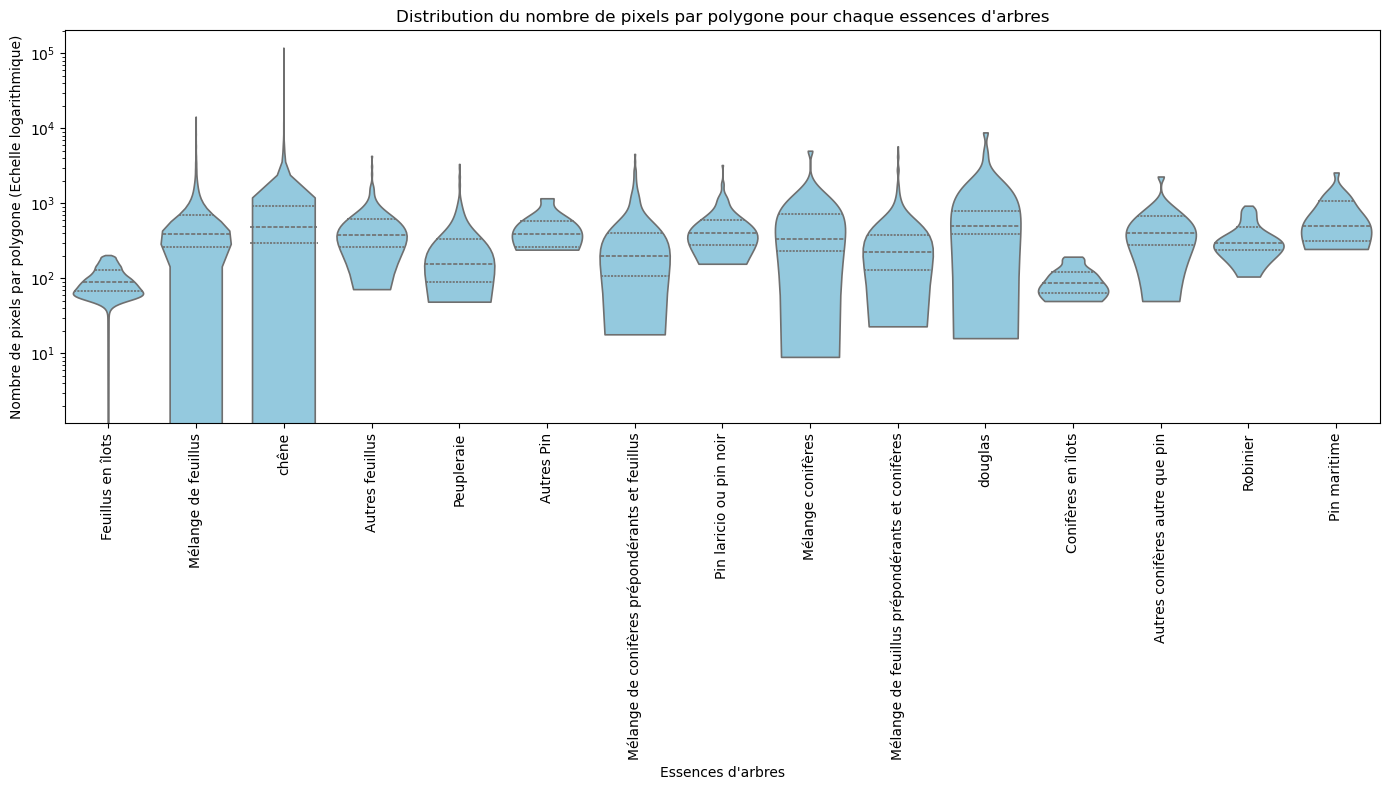

In [7]:
raster_path = "/home/onyxia/work/projet_teledec_2024/raster.tif"
shapefile_path = "/home/onyxia/work/projet_teledec_2024/Sample_BD_foret_T31TCJ.shp"
output_path = "/home/onyxia/work/projet_teledec_2024/violin_plot_nb_pix_par_poly_par_classe.png"
pixels_per_polygons_per_class(raster_path, shapefile_path, output_path)
print("Diagramme en violon créé et enregistré avec succès !")